In [3]:
import pandas as pd
from sklearn.cluster import KMeans
import pickle


In [8]:
import pandas as pd
from sklearn.cluster import KMeans
import pickle

# Cargar el archivo de inmuebles en venta
df = pd.read_csv('inmuebles_venta_encoding.csv')

# Definir las características a usar y corregir los nombres de las columnas
features = ['Precio', 'Superficie Construida', 'Superficie Útil', 'CP_encoded']

# Convertir a NaN los valores no numéricos en las columnas seleccionadas
for feature in features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

# Llenar los valores NaN con la media de cada columna (sin eliminar filas)
df[features] = df[features].fillna(df[features].mean())

# Configurar y entrenar el modelo KMeans
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(df[features])

# Guardar el modelo de clustering en un archivo pickle
with open('venta_pickles/kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Guardar el DataFrame procesado con la columna de clusters
df.to_csv('inmuebles_venta_procesado_clustering.csv', index=False)

print("Clustering aplicado y etiquetado. Archivo con etiquetas de cluster guardado.")


Clustering aplicado y etiquetado. Archivo con etiquetas de cluster guardado.


Índice de Silueta para el clustering: 0.62


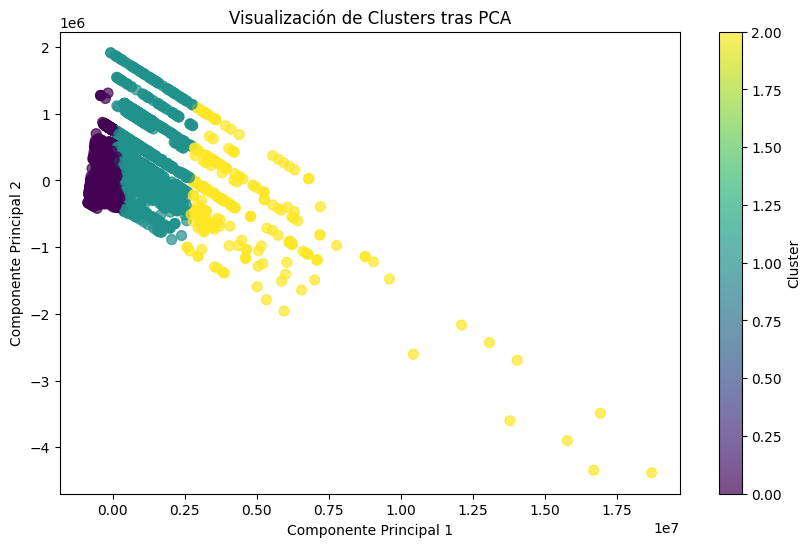

Tamaño de cada cluster:
cluster
0    7009
1    2035
2     260
Name: count, dtype: int64


In [9]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Cargar el DataFrame con los resultados del clustering
df = pd.read_csv('inmuebles_venta_procesado_clustering.csv')

# Seleccionar las características y la columna de cluster
features = ['Precio', 'Superficie Construida', 'Superficie Útil', 'CP_encoded']
clusters = df['cluster']

# 1. Calcular el Índice de Silueta para evaluar la calidad del clustering
silhouette_avg = silhouette_score(df[features], clusters)
print(f"Índice de Silueta para el clustering: {silhouette_avg:.2f}")

# 2. Reducción de dimensiones para visualización con PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df[features])

# Crear un scatter plot de los clusters en el espacio reducido
plt.figure(figsize=(10, 6))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.7)
plt.title("Visualización de Clusters tras PCA")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Cluster')
plt.show()

# 3. Tamaño de cada cluster
cluster_sizes = df['cluster'].value_counts()
print("Tamaño de cada cluster:")
print(cluster_sizes)


---------------------------

# SQLITE


In [10]:
import sqlite3

# Intentar conectarse a la base de datos
db_path = "venta_inmuebles.db"

try:
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("PRAGMA integrity_check;")
    result = cursor.fetchall()
    print("Resultado de la verificación de integridad:", result)
    conn.close()
except Exception as e:
    print("Error al verificar la base de datos:", e)


Resultado de la verificación de integridad: [('ok',)]


In [11]:
import sqlite3
import pandas as pd

# Ruta del archivo de la base de datos SQLite
db_path = "venta_inmuebles.db"

# Conectar a la base de datos existente
conn = sqlite3.connect(db_path)
cursor = conn.cursor()

# Verificar si la tabla `inmuebles` ya existe
query_show_tables = "SELECT name FROM sqlite_master WHERE type='table';"
tables = cursor.execute(query_show_tables).fetchall()

# Comprobar si la tabla `inmuebles` existe
if 'inmuebles' in [table[0] for table in tables]:
    # Verificar si la columna `cluster` ya existe en la tabla
    query_check_columns = "PRAGMA table_info(inmuebles);"
    columns = cursor.execute(query_check_columns).fetchall()
    column_names = [col[1] for col in columns]

    if 'cluster' not in column_names:
        # Añadir la columna `cluster` si no existe
        cursor.execute("ALTER TABLE inmuebles ADD COLUMN cluster INTEGER;")
        print("Columna `cluster` añadida a la tabla `inmuebles`.")
    else:
        print("La columna `cluster` ya existe en la tabla `inmuebles`.")

    # Cargar el archivo CSV con clustering
    clustering_file_path = "inmuebles_venta_procesado_clustering.csv"
    df_clustering = pd.read_csv(clustering_file_path)

    # Actualizar la columna `cluster` usando `Descripción` como clave
    update_query = """
    UPDATE inmuebles
    SET cluster = ?
    WHERE descripcion = ?;
    """
    for index, row in df_clustering.iterrows():
        cursor.execute(update_query, (row['cluster'], row['Descripción']))

    print("Datos de clustering actualizados en la tabla `inmuebles`.")

    # Verificar el resultado de la actualización
    query_check = "SELECT COUNT(*) AS total_registros, COUNT(DISTINCT cluster) AS num_clusters FROM inmuebles;"
    result = pd.read_sql_query(query_check, conn)

    # Guardar los cambios y cerrar la conexión
    conn.commit()
    conn.close()

    # Mostrar el resultado usando Pandas
    print("Resumen de Inmuebles:")
    print(result)

else:
    print("La tabla `inmuebles` no existe en la base de datos.")


Columna `cluster` añadida a la tabla `inmuebles`.
Datos de clustering actualizados en la tabla `inmuebles`.
Resumen de Inmuebles:
   total_registros  num_clusters
0             9350             3
